In [1]:
import warnings
import math
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot
import scanpy as sc
import anndata as ad
from wot.ot import util
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
import sklearn
import scipy

In [4]:
ot_config = {'local_pca': 5, 'growth_iters': 1, 'epsilon': 0.05, 'lambda1': 1, 'lambda2': 50,
                          'epsilon0': 1, 'tau': 10000, 'scaling_iter': 3000, 'inner_iter_max': 50, 'tolerance': 1e-8,
                          'max_iter': 1e7, 'batch_size': 5, 'extra_iter': 1000}

In [5]:
def compute_default_cost_matrix(a, b, eigenvals=None):

    if eigenvals is not None:
        a = a.dot(eigenvals)
        b = b.dot(eigenvals)

    cost_matrix = sklearn.metrics.pairwise.pairwise_distances(a.toarray() if scipy.sparse.isspmatrix(a) else a,
                                                              b.toarray() if scipy.sparse.isspmatrix(b) else b,
                                                              metric='sqeuclidean', n_jobs=-1)
    cost_matrix = cost_matrix / np.median(cost_matrix)
    return cost_matrix

In [6]:
# Calculate the OT map


def compute_transport_matrix(solver, **params):
    """
    Compute the optimal transport with stabilized numerics.
    Args:
    G: Growth (absolute)
    solver: transport_stablev2 or optimal_transport_duality_gap
    growth_iters:
  """

    import gc
    G = params['G']
    growth_iters = params['growth_iters']
    learned_growth = []
    for i in range(growth_iters):
        if i == 0:
            row_sums = G
        else:
            row_sums = tmap.sum(axis=1)  # / tmap.shape[1]
        params['G'] = row_sums
        learned_growth.append(row_sums)
        tmap,best_cost = solver(**params)
        gc.collect()

    return tmap, learned_growth,best_cost


#-----------------------------------------#



def optimal_transport_duality_gap(C, G, lambda1, lambda2, epsilon, batch_size, tolerance, tau,
                                  epsilon0, max_iter, **ignored):
    """
    Compute the optimal transport with stabilized numerics, with the guarantee that the duality gap is at most `tolerance`

    Parameters
    ----------
    C : 2-D ndarray
        The cost matrix. C[i][j] is the cost to transport cell i to cell j
    G : 1-D array_like
        Growth value for input cells.
    lambda1 : float, optional
        Regularization parameter for the marginal constraint on p
    lambda2 : float, optional
        Regularization parameter for the marginal constraint on q
    epsilon : float, optional
        Entropy regularization parameter.
    batch_size : int, optional
        Number of iterations to perform between each duality gap check
    tolerance : float, optional
        Upper bound on the duality gap that the resulting transport map must guarantee.
    tau : float, optional
        Threshold at which to perform numerical stabilization
    epsilon0 : float, optional
        Starting value for exponentially-decreasing epsilon
    max_iter : int, optional
        Maximum number of iterations. Print a warning and return if it is reached, even without convergence.

    Returns
    -------
    transport_map : 2-D ndarray
        The entropy-regularized unbalanced transport map
    """
    C = np.asarray(C, dtype=np.float64)
    scale_factor = []
    epsilon_scalings = 5
    for j in range(C.shape[0]):
        scale_factor[j] = np.exp(- np.log(epsilon[j]) / epsilon_scalings)
        epsilon_i[j] = epsilon0 * scale_factor[j]


    I, J = C.shape
    dx, dy = np.ones(I) / I, np.ones(J) / J

    p = G
    q = np.ones(C.shape[1]) * np.average(G)

    u, v = np.zeros(I), np.zeros(J)
    a, b = np.ones(I), np.ones(J)

    epsilon_i = epsilon0 * scale_factor
    current_iter = 0

    for e in range(epsilon_scalings + 1):
        duality_gap = np.inf
        u = u + epsilon_i * np.log(a)
        v = v + epsilon_i * np.log(b)  # absorb
        epsilon_i = epsilon_i / scale_factor
        _K = np.exp(-C / epsilon_i)
        alpha1 = lambda1 / (lambda1 + epsilon_i)
        alpha2 = lambda2 / (lambda2 + epsilon_i)
        K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
        a, b = np.ones(I), np.ones(J)
        old_a, old_b = a, b
        threshold = tolerance if e == epsilon_scalings else 1e-6

        while duality_gap > threshold:
            for i in range(batch_size if e == epsilon_scalings else 5):
                current_iter += 1
                old_a, old_b = a, b
                a = (p / (K.dot(np.multiply(b, dy)))) ** alpha1 * np.exp(-u / (lambda1 + epsilon_i))
                b = (q / (K.T.dot(np.multiply(a, dx)))) ** alpha2 * np.exp(-v / (lambda2 + epsilon_i))

                # stabilization
                if (max(max(abs(a)), max(abs(b))) > tau):
                    u = u + epsilon_i * np.log(a)
                    v = v + epsilon_i * np.log(b)  # absorb
                    K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
                    a, b = np.ones(I), np.ones(J)

                if current_iter >= max_iter:
                    logger.warning("Reached max_iter with duality gap still above threshold. Returning")
                    return (K.T * a).T * b

            # The real dual variables. a and b are only the stabilized variables
            _a = a * np.exp(u / epsilon_i)
            _b = b * np.exp(v / epsilon_i)

            # Skip duality gap computation for the first epsilon scalings, use dual variables evolution instead
            if e == epsilon_scalings:
                R = (K.T * a).T * b
                pri = primal(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
                dua = dual(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
                duality_gap = (pri - dua) / abs(pri)
            else:
                duality_gap = max(
                    np.linalg.norm(_a - old_a * np.exp(u / epsilon_i)) / (1 + np.linalg.norm(_a)),
                    np.linalg.norm(_b - old_b * np.exp(v / epsilon_i)) / (1 + np.linalg.norm(_b)))

    if np.isnan(duality_gap):
        raise RuntimeError("Overflow encountered in duality gap computation, please report this incident")
    # min_cost = np.multiply(C*(R/C.shape[1])) + lambda1*
    return R/C.shape[1], np.sum(C * (R/C.shape[1]))



#-----------------------------------------------------------------------------------------------------------------------------#
# @ Lénaïc Chizat 2015 - optimal transport
def fdiv(l, x, p, dx):
    return np.sum(l * (dx * (x * (np.log(x / p)) - x + p)))

def new_fdiv(l, x, p, dx):
    return (l * (dx * (x * (np.log(x / p)) - x + p)))


def fdivstar(l, u, p, dx):
    return np.sum(l*(p * dx) * (np.exp(u / l) - 1))

def primal(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1 = lambda x, y: fdiv(lambda1, x, p, y)
    F2 = lambda x, y: fdiv(lambda2, x, q, y)
    with np.errstate(divide='ignore'):
        return F1(np.dot(R, dy), dx) + F2(np.dot(R.T, dx), dy) \
               + (epsilon * np.sum(R * np.nan_to_num(np.log(R)) - R + K) \
                  + np.sum(R * C)) / (I * J)

def primal_first_term(C,K,R,p,q,epsilon):
    I = len(p)
    J = len(q)
    with np.errstate(divide='ignore'):
        return np.sum(R * C) / (I * J)


def primal_second_term(C,K,R,p,q,epsilon):
    I = len(p)
    J = len(q)
    with np.errstate(divide='ignore'):
        return (epsilon * np.sum(R * np.nan_to_num(np.log(R)) - R + K)) / (I * J)


def primal_third_term(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1 = lambda x, y: fdiv(lambda1, x, p, y)
    F2 = lambda x, y: fdiv(lambda2, x, q, y)
    with np.errstate(divide='ignore'):
        return F1(np.dot(R, dy), dx)


def primal_ind_third_term(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1 = lambda x, y: new_fdiv(lambda1, x, p, y)
    F2 = lambda x, y: new_fdiv(lambda2, x, q, y)
    with np.errstate(divide='ignore'):
        return F1(np.dot(R, dy), dx)


def primal_fourth_term(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1 = lambda x, y: fdiv(lambda1, x, p, y)
    F2 = lambda x, y: fdiv(lambda2, x, q, y)
    with np.errstate(divide='ignore'):
        return F2(np.dot(R.T, dx), dy) 


def primal_ind_fourth_term(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1 = lambda x, y: fdiv(lambda1, x, p, y)
    F2 = lambda x, y: new_fdiv(lambda2, x, q, y)
    with np.errstate(divide='ignore'):
        return F2(np.dot(R.T, dx), dy) 

def dual(C, K, R, dx, dy, p, q, a, b, epsilon, lambda1, lambda2):
    I = len(p)
    J = len(q)
    F1c = lambda u, v: fdivstar(lambda1, u, p, v)
    F2c = lambda u, v: fdivstar(lambda2, u, q, v)
    return - F1c(- epsilon * np.log(a), dx) - F2c(- epsilon * np.log(b), dy) \
           - epsilon * np.sum(R - K) / (I * J)


# end @ Lénaïc Chizat


## Experiment with looping through values of epsilon

In [12]:
import numpy as np
import pandas as pd
import anndata as ad

# Parameters
num_genes = 718
num_obs = 9980
num_time_points = 4
num_clusters_per_time_point = 5

# Create a random gene expression matrix
X = np.random.rand(num_obs, num_genes)

# Create observation (cell) metadata
obs = pd.DataFrame(index=[f'cell_{i}' for i in range(num_obs)])
obs['time_point'] = np.repeat(np.arange(num_time_points), num_obs // num_time_points)
obs['cluster'] = np.tile(np.repeat(np.arange(num_clusters_per_time_point), num_obs // (num_time_points * num_clusters_per_time_point)), num_time_points)

# Correct any rounding issues if num_obs is not perfectly divisible
if len(obs) < num_obs:
    extra_obs = num_obs - len(obs)
    additional_data = pd.DataFrame({'time_point': [num_time_points-1] * extra_obs, 'cluster': [num_clusters_per_time_point-1] * extra_obs},
                                   index=[f'cell_{len(obs) + i}' for i in range(extra_obs)])
    obs = pd.concat([obs, additional_data])

# Create variable (gene) metadata
var = pd.DataFrame(index=[f'gene_{i}' for i in range(num_genes)])

# Create the AnnData object
adata = ad.AnnData(X=X, obs=obs, var=var)

# Display the created AnnData object
print(adata)
print(adata.obs.head())
print(adata.var.head())


AnnData object with n_obs × n_vars = 9980 × 718
    obs: 'time_point', 'cluster'
        time_point  cluster
cell_0           0        0
cell_1           0        0
cell_2           0        0
cell_3           0        0
cell_4           0        0
Empty DataFrame
Columns: []
Index: [gene_0, gene_1, gene_2, gene_3, gene_4]


In [13]:
sc.tl.pca(adata, n_comps=5)

In [14]:
import numpy as np
from scipy.spatial import ConvexHull

# Function to calculate the volume of the convex hull
def calculate_hull_volume(points):
    if points.shape[0] > points.shape[1]:
        hull = ConvexHull(points)
        return hull.volume
    else:
        return 0  # If there are fewer points than dimensions, the volume is 0

# Split data based on time points and calculate the volume of each cluster
volumes = {}

for time_point in adata.obs['time_point'].unique():
    volumes[time_point] = {}
    tp_data = adata[adata.obs['time_point'] == time_point]
    
    for cluster in tp_data.obs['cluster'].unique():
        cluster_data = tp_data[tp_data.obs['cluster'] == cluster]
        
        # Get the PCA coordinates for the current cluster
        pca_coords = cluster_data.obsm['X_pca']
        
        # Calculate the volume of the convex hull in the PCA space
        volume = calculate_hull_volume(pca_coords)
        volumes[time_point][cluster] = volume

# Display the calculated volumes
for time_point, clusters in volumes.items():
    print(f"Time Point {time_point}:")
    for cluster, volume in clusters.items():
        print(f"  Cluster {cluster}: Volume = {volume}")


Time Point 0:
  Cluster 0: Volume = 4.44502610147842
  Cluster 1: Volume = 3.926194715249151
  Cluster 2: Volume = 4.003082049209411
  Cluster 3: Volume = 4.498653458096368
  Cluster 4: Volume = 4.161528317982485
Time Point 1:
  Cluster 0: Volume = 4.219998159420956
  Cluster 1: Volume = 4.342748731432332
  Cluster 2: Volume = 4.555520035960411
  Cluster 3: Volume = 4.1508079371469835
  Cluster 4: Volume = 4.168006908392322
Time Point 2:
  Cluster 0: Volume = 3.884810180964626
  Cluster 1: Volume = 3.5592183161597992
  Cluster 2: Volume = 4.442496339671277
  Cluster 3: Volume = 4.164147981427845
  Cluster 4: Volume = 4.269504817599419
Time Point 3:
  Cluster 0: Volume = 4.364096172596397
  Cluster 1: Volume = 3.5454543846022006
  Cluster 2: Volume = 4.175690007890936
  Cluster 3: Volume = 4.861639262976775
  Cluster 4: Volume = 4.294856245346594


In [45]:

# Create an empty DataFrame to store the volumes
volumes_list = []

# Iterate over consecutive pairs of time points
for time_point in range(adata.obs['time_point'].min(), adata.obs['time_point'].max()):
    # Subset the AnnData object for the current and next time points
    current_tp_data = adata[adata.obs['time_point'] == time_point]
    next_tp_data = adata[adata.obs['time_point'] == time_point + 1]
    
    # Perform PCA for the current time point
    sc.tl.pca(current_tp_data, n_comps=5)
    
    # Calculate the convex hull volumes for clusters in the current time point
    for cluster in current_tp_data.obs['cluster'].unique():
        cluster_data = current_tp_data[current_tp_data.obs['cluster'] == cluster]
        
        # Get the PCA coordinates for the current cluster
        pca_coords = cluster_data.obsm['X_pca']
        
        # Calculate the volume of the convex hull in the PCA space
        volume = calculate_hull_volume(pca_coords)
        
        volumes_list.append({'time':time_point,'cluster':cluster,'volume':volume})

volumes_df = pd.DataFrame(volumes_list)
# Display the DataFrame
print(volumes_df)

    time  cluster     volume
0      0        0  11.951941
1      0        1  10.437877
2      0        2  13.509781
3      0        3   9.561529
4      0        4  11.162479
5      1        0   8.983288
6      1        1  10.715847
7      1        2  10.112391
8      1        3  11.634790
9      1        4  12.986123
10     2        0  11.315418
11     2        1   8.846434
12     2        2  11.980569
13     2        3  10.104243
14     2        4  10.093106


In [6]:
import functools
import time

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ott
from ott import problems
from ott.geometry import geometry, pointcloud
from ott.solvers import linear
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

In [2]:
import io

import requests

import numpy as np

response = requests.get("https://marcocuturi.net/embeddings.npz")
data = np.load(io.BytesIO(response.content))

In [3]:
X, HIST = data.get("X"), data.get("HIST")

In [4]:
geom = pointcloud.PointCloud(X)
print(
    "median cost:",
    geom.median_cost_matrix,
    " mean cost:",
    geom.mean_cost_matrix,
)

median cost: 0.4035166  mean cost: 0.41272438


In [6]:
cost = geom.cost_matrix
print(" max:", jnp.max(geom.cost_matrix))

 max: 1.4388261


In [7]:
epsilon = 1e-2

In [8]:
n_iters = []
for i in range(13):
    n_iters.append(
        linear.solve(
            geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
            lse_mode=False,
            a=HIST[0, :],
            b=HIST[1 + i, :],
        ).n_iters
    )
print(np.array(n_iters))

[300  60  70  90 120 100 120 120  80  70  80 110 110]


In [9]:
def sink(a, b, cost, epsilon, min_iterations, max_iterations):
    return linear.solve(
        geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
        a=a,
        b=b,
        lse_mode=False,
        min_iterations=min_iterations,
        max_iterations=max_iterations,
    ).reg_ot_cost

In [11]:
sink_div_2vmap = jax.jit(
    jax.vmap(jax.vmap(sink, [0] + [None] * 5, 0), [None, 0] + [None] * 4, 1),
    static_argnums=[4, 5],
)

In [12]:
HIST_a = jnp.array(HIST[0:45])
HIST_b = jnp.array(HIST[-37:])
print(HIST_a.shape, HIST_b.shape, cost.shape)

(45, 4000) (37, 4000) (4000, 4000)


In [15]:
epsilon = 1e-2
# Naive Vmapping
%time out_1 = DIV = sink_div_2vmap(HIST_a, HIST_b, cost, epsilon, 0, 100).block_until_ready()

2024-06-12 16:43:33.448691: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 4.01GiB (4303873669 bytes) by rematerialization; only reduced to 99.60GiB (106949394939 bytes), down from 99.61GiB (106951035315 bytes) originally
2024-06-12 16:43:43.795449: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 99.52GiB (rounded to 106858729472)requested by op 
2024-06-12 16:43:43.795669: W external/tsl/tsl/framework/bfc_allocator.cc:494] **__________________________________________________________________________________________________
E0612 16:43:43.795712  184326 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 106858729456 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 106858729456 bytes.

In [16]:
def my_sinkhorn(
    geom: geometry.Geometry, a: jnp.ndarray, b: jnp.ndarray, **kwargs
):
    return linear.solve(
        geom, a, b, inner_iterations=1, max_iterations=10_000, **kwargs
    )

In [17]:
ind = jnp.argsort(jnp.sum(jnp.array(HIST) > 0, axis=1))
a, b = HIST[ind[-2]], HIST[ind[-1]]
print(
    f"Histogram `a` supported on {jnp.sum(a >0)} words, `b` on {jnp.sum(b >0)} words"
)

Histogram `a` supported on 1121 words, `b` on 1162 words


In [18]:
out_eps, leg_eps = [], []
epsilons = [1e-3, 0.3 * 1e-2, 1e-2, 0.3 * 1e-1, 1e-1]
ran_in = np.zeros((len(epsilons),))
for i, epsilon in enumerate(epsilons):
    tic = time.perf_counter()
    out_eps.append(my_sinkhorn(geometry.Geometry(cost, epsilon=epsilon), a, b))
    toc = time.perf_counter()
    ran_in[i] = toc - tic
    leg_eps.append(
        r"$\varepsilon$"
        + f"= {epsilon}, reg_ot_cost = {out_eps[-1].reg_ot_cost:.2f}"
    )

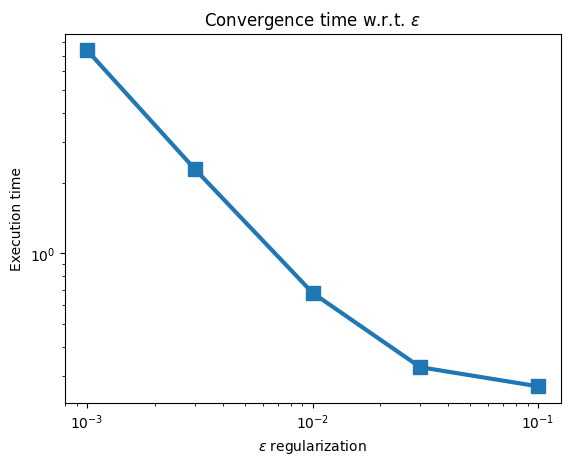

In [19]:
plt.plot(epsilons, ran_in, marker="s", markersize=10, linewidth=3)
plt.title(r"Convergence time w.r.t. $\varepsilon$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\varepsilon$ regularization")
plt.ylabel("Execution time")
plt.show()

In [20]:
def plot_results(
    out, leg, loc="lower left", title="", xlabel="", ylabel="", ylim=(0.0005, 5)
):
    plt.figure(figsize=(12, 9))
    for out_ in out:
        plt.plot(out_.errors[out_.errors > -1], linewidth=3)
    plt.legend(leg, loc=loc)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim)
    plt.show()

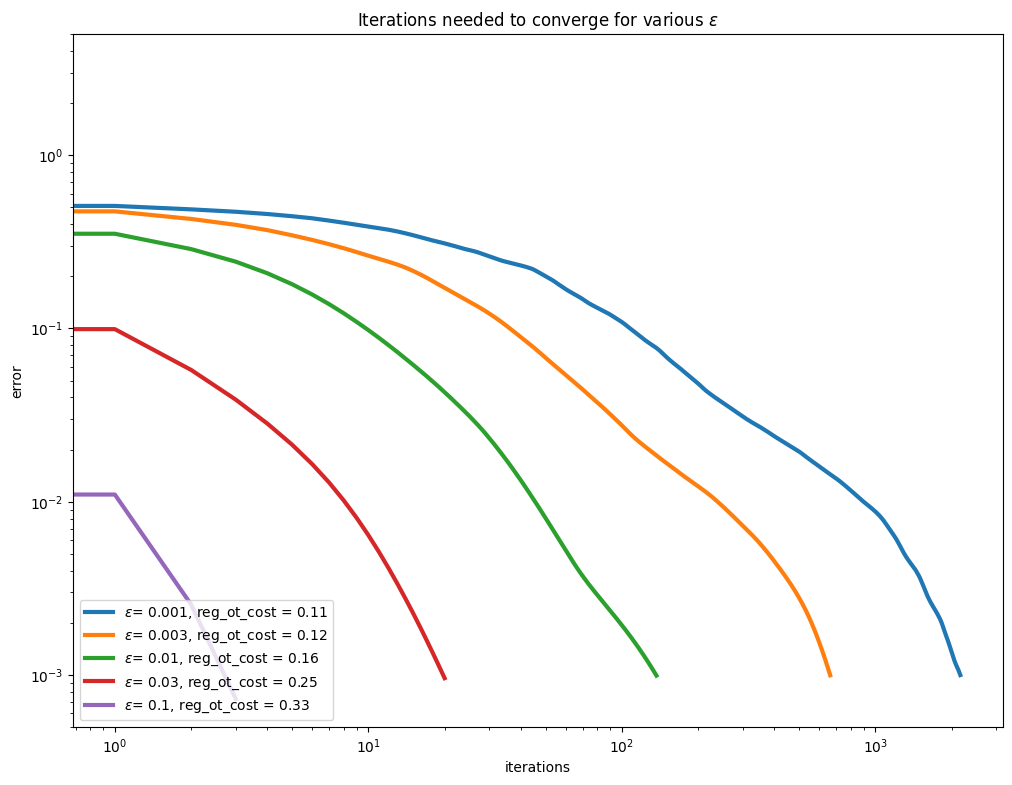

In [21]:
plot_results(
    out_eps,
    leg_eps,
    title=r"Iterations needed to converge for various $\varepsilon$",
    xlabel="iterations",
    ylabel="error",
)

In [23]:
leg_eps

['$\\varepsilon$= 0.001, reg_ot_cost = 0.11',
 '$\\varepsilon$= 0.003, reg_ot_cost = 0.12',
 '$\\varepsilon$= 0.01, reg_ot_cost = 0.16',
 '$\\varepsilon$= 0.03, reg_ot_cost = 0.25',
 '$\\varepsilon$= 0.1, reg_ot_cost = 0.33']

In [24]:
epsilons = [1e-4, 1e-3, 1e-2]
out_baseline, leg_baseline = [], []
for epsilon in epsilons:
    out_baseline.append(
        my_sinkhorn(geometry.Geometry(cost, epsilon=epsilon), a, b)
    )
    leg_baseline.append("Baseline")

In [25]:
out_mom, leg_mom = [], []
for i, epsilon in enumerate(epsilons):
    out_mom.append([out_baseline[i]])  # initialize with baseline
    leg_mom.append([leg_baseline[i]])  # initialize with baseline
    for mom in [0.8, 1.05, 1.1, 1.3]:
        out_mom[i].append(
            my_sinkhorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                momentum=acceleration.Momentum(value=mom),
            )
        )
        leg_mom[i].append(f"Momentum : {mom}")

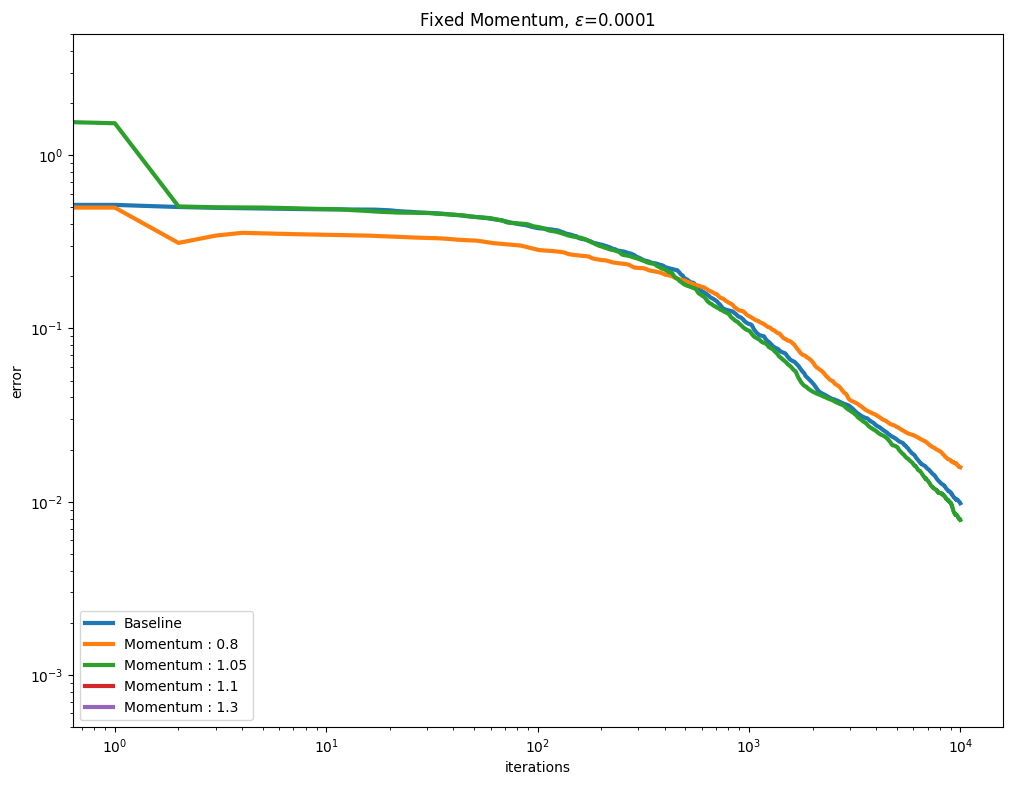

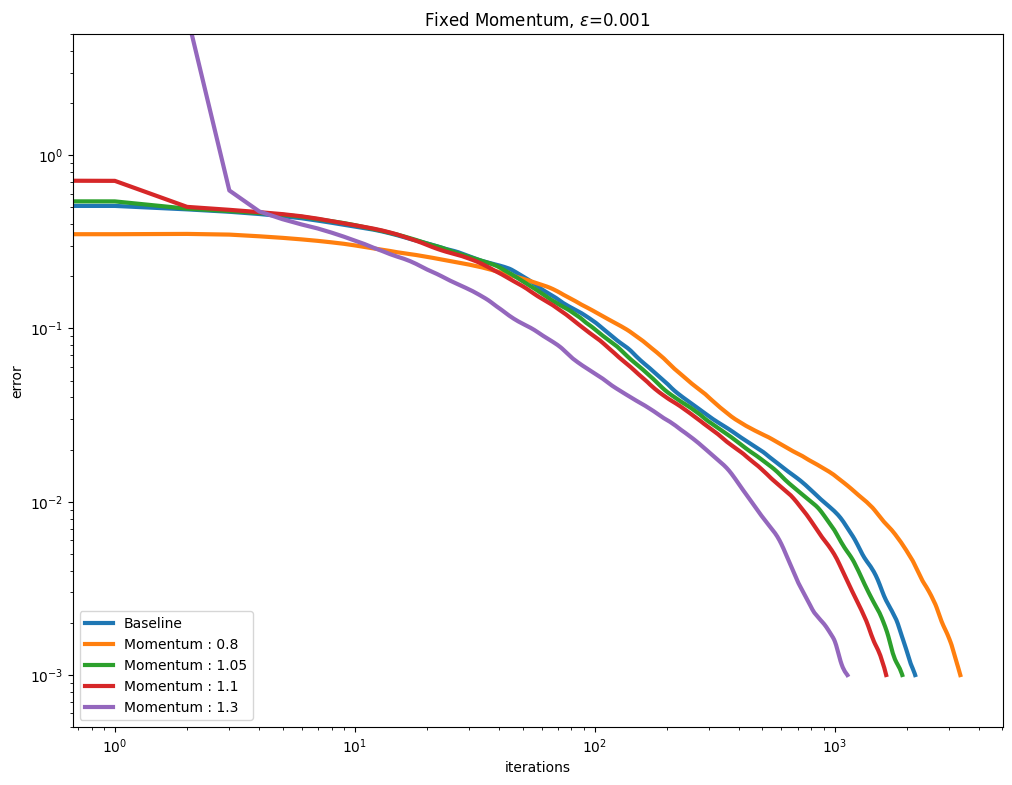

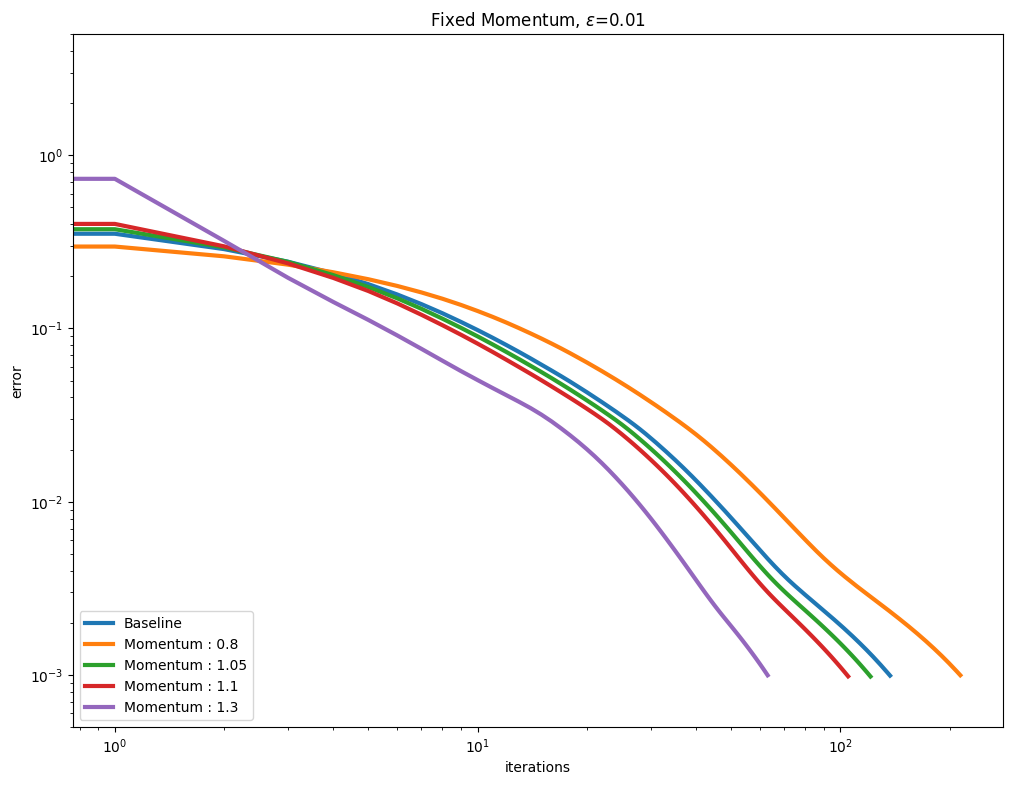

In [26]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_mom[i],
        leg_mom[i],
        title=r"Fixed Momentum, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

In [27]:
out_scaling, leg_scaling = [], []
for i, epsilon in enumerate(epsilons):
    out_scaling.append([out_baseline[i]])
    leg_scaling.append([leg_baseline[i]])
    for decay in [0.8, 0.95]:
        for init in [5, 50, 100]:
            Epsilon = geometry.epsilon_scheduler.Epsilon(
                target=epsilon, init=init, decay=decay
            )
            out_scaling[i].append(
                my_sinkhorn(
                    geometry.Geometry(cost, epsilon=Epsilon),
                    a,
                    b,
                )
            )
            leg_scaling[i].append(
                rf"Decay: {decay}, Init: {init} $\varepsilon$"
            )

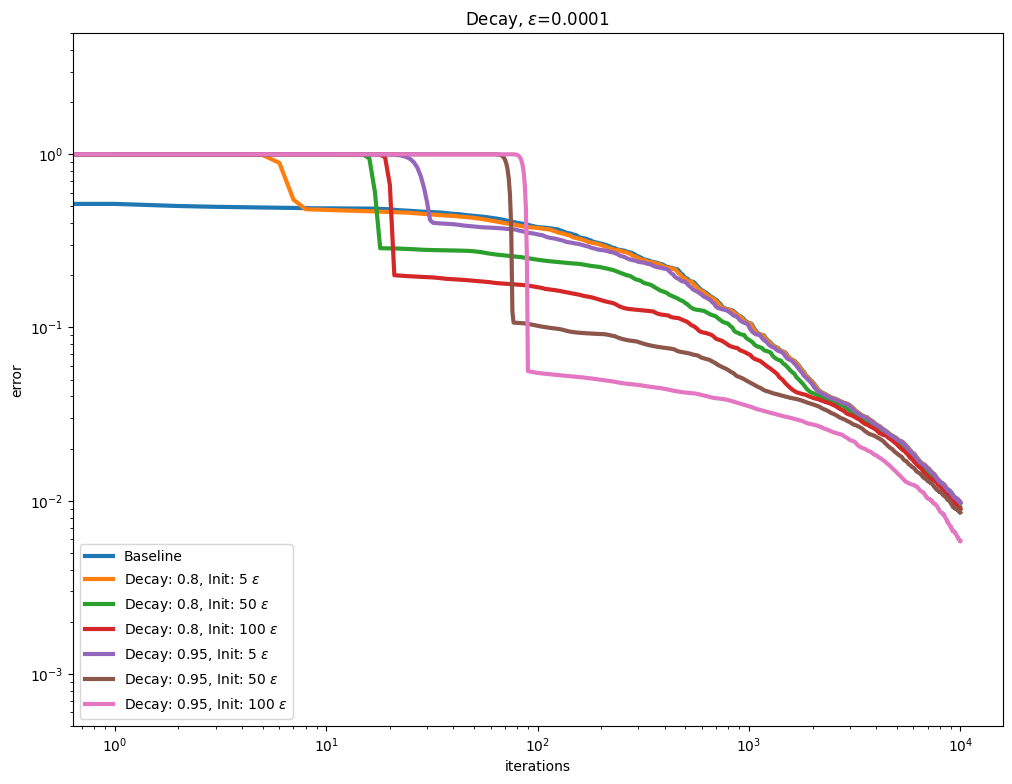

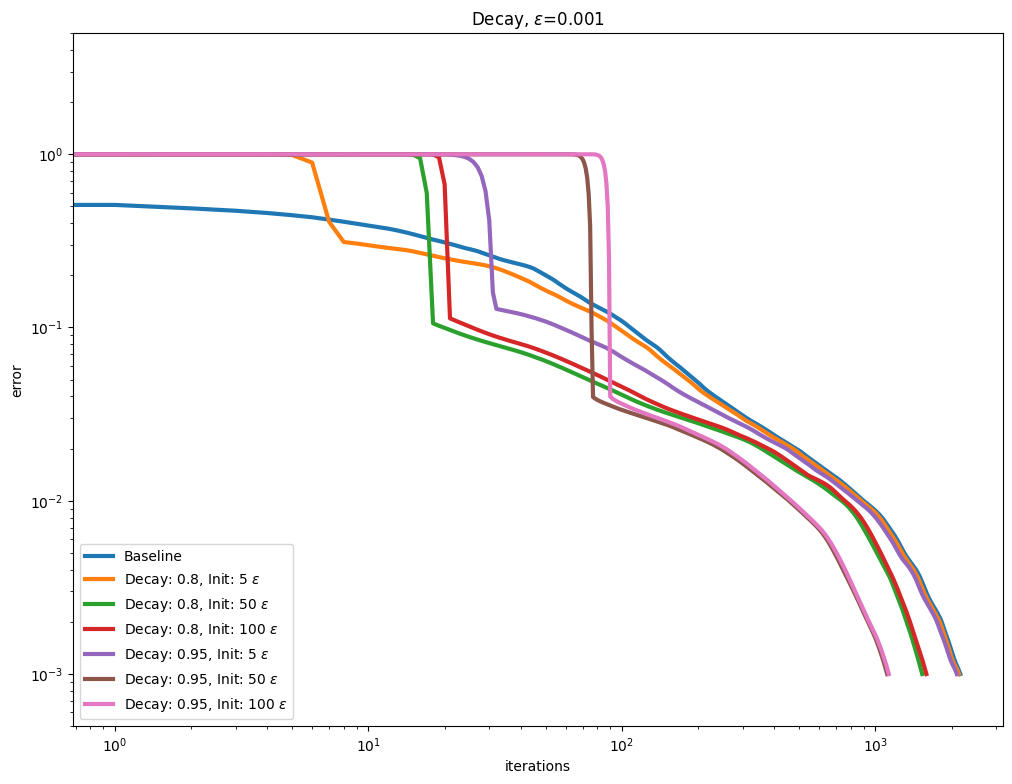

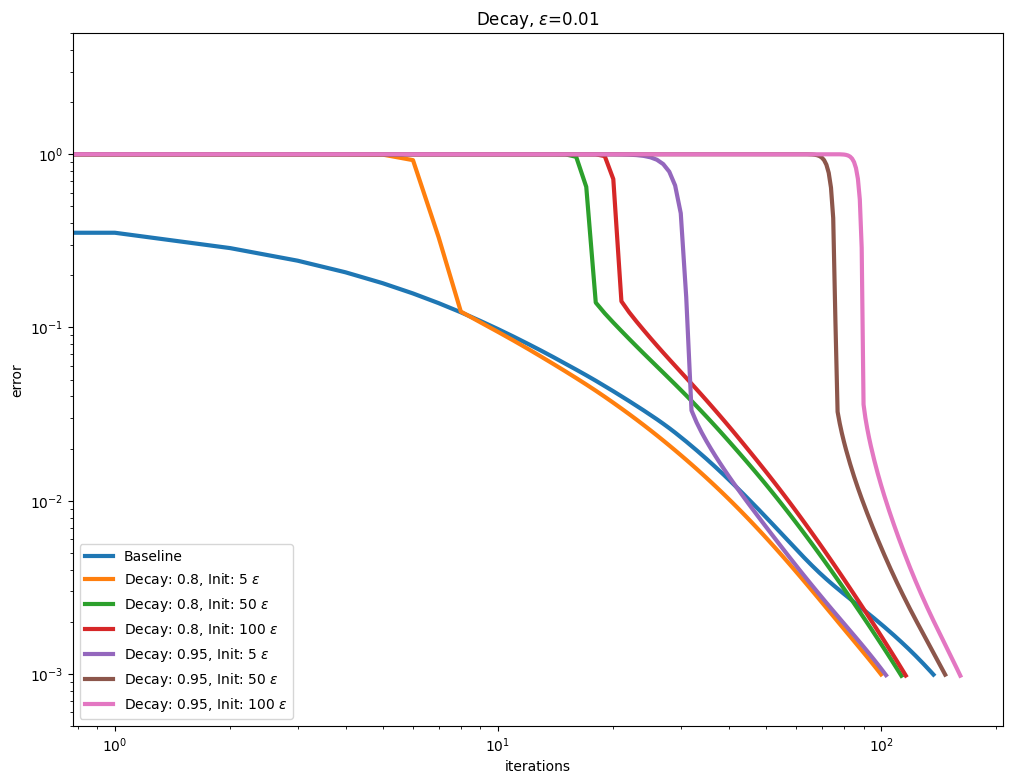

In [28]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_scaling[i],
        leg_scaling[i],
        title=rf"Decay, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

In [30]:
geometry.epsilon_scheduler.Epsilon(target=0.05,scale_epsilon=5,init=0.5,decay=0.2)

In [33]:
Epsilon.at(100)

Array(0.01, dtype=float32, weak_type=True)

In [34]:
acceleration.

<module 'ott.solvers.linear.acceleration' from '/home/shashank/micromamba/envs/sc_rna/lib/python3.11/site-packages/ott/solvers/linear/acceleration.py'>

In [7]:
epsilon=0.05
epsilon0 = 1
epsilon_scalings = 5
scale_factor = np.exp(-np.log(epsilon)/ epsilon_scalings)
epsilon_i = epsilon0*scale_factor

In [16]:
import numpy as np
import pandas as pd

# Initialize a list to collect dataframes of arrays and their identifiers for all outer loop iterations
final_results = []

# Example nested loops that generate arrays
for i in range(3):  # Outer loop
    inner_results = []  # List to collect dataframes for the current outer loop iteration
    for j in range(2):  # Inner loop
        x = np.random.randint(1, 5)  # Random row size for each iteration of the inner loop
        y = np.random.randint(3, 7)  # Random column size for each iteration of the inner loop
        array = np.random.rand(x, y)  # Generate an array of shape (x, y)
        
        # Create a dataframe for the current array and its identifiers
        df = pd.DataFrame(array)
        df['Outer Loop'] = i
        df['Inner Loop'] = j
        inner_results.append(df)
    
    # Concatenate all dataframes from the inner loop
    merged_inner_results = pd.concat(inner_results, ignore_index=True)
    final_results.append(merged_inner_results)

# Concatenate all dataframes from the outer loop
combined_df = pd.concat(final_results, ignore_index=True)

# Print the final combined dataframe
print(combined_df)


           0         1         2         3         4  Outer Loop  Inner Loop  \
0   0.601123  0.023161  0.602810  0.936509  0.780372           0           0   
1   0.180654  0.375187  0.354067  0.148081  0.305704           0           0   
2   0.690365  0.144038  0.725507  0.690533  0.138490           0           0   
3   0.583654  0.098783  0.933362  0.527594  0.832765           0           0   
4   0.931124  0.270931  0.676069  0.095090  0.685263           0           1   
5   0.091299  0.308776  0.640286  0.923380  0.281391           1           0   
6   0.975247  0.819980  0.662908  0.767755  0.931847           1           0   
7   0.776563  0.465319  0.510977  0.179835       NaN           1           1   
8   0.174381  0.157238  0.193186  0.870716       NaN           2           0   
9   0.205830  0.593254  0.199861  0.379278       NaN           2           0   
10  0.463935  0.159329  0.266452  0.410029       NaN           2           0   
11  0.094976  0.116206  0.287126  0.8401

In [17]:
df

,0,1,2,3,Outer Loop,Inner Loop
0,0.094976,0.116206,0.287126,0.840177,2,1


# Create a test case for the sinkhorn algo


In [11]:
C = np.random.rand(10,15)

In [8]:
C = C*2

In [12]:
C.shape

(10, 15)

In [13]:
#G = np.ones(10)
G=np.random.rand(10,)
#G = G.tolist()

In [18]:
G = G*2 

In [14]:
G.mean()

np.float64(0.3698934828544943)

In [15]:
G = G*1.5

In [169]:
max_growth_rate = G*5

In [170]:
max_growth_rate

array([3.99438828, 1.05164719, 0.82404569, 1.6555555 , 2.66650625,
       4.02123999, 3.98142787, 1.64119792, 0.92717083, 4.12727827,
       2.81231321, 1.89246902, 1.26464111, 2.41708062, 0.95148546])

In [16]:
lambda1 = 1
lambda2 = 50

In [18]:
tau = 1000
max_iter = 1e7
scaling_iter = 3000
inner_iter_max = 50
tolerance = 1e-8
batch_size = 5
extra_iter = 1000

epsilon = 0.5
epsilon0 = 1
epsilon_scalings = 5
scale_factor = np.exp(-np.log(epsilon)/epsilon_scalings)

pri_df = pd.DataFrame()

I,J = C.shape
dx,dy = np.ones(I) / I, np.ones(J) / J

p = G
q = np.ones(C.shape[1]) * np.average(G)

u,v = np.zeros(I), np.zeros(J)
a,b = np.ones(I), np.ones(J)

epsilon_i = epsilon0 * scale_factor

current_iter = 0

for e in range(epsilon_scalings +1):
    duality_gap = np.inf
    #print(duality_gap)
    u = u + epsilon_i*np.log(a)
    #print("This is the value of u at iterate",e,"is",u)
    v = v + epsilon_i*np.log(b)
    #print("This is the value of v at iterate",e,"is",v)
    epsilon_i = epsilon_i / scale_factor
    print("This is epsilon after scaling",epsilon_i)
    _K = np.exp(-C / epsilon_i)
    alpha1 = lambda1 / (lambda1 + epsilon_i)
    alpha2 = lambda2 / (lambda2 + epsilon_i)
    K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
    a,b = np.ones(I),np.ones(J)
    old_a,old_b = a,b
    threshold = tolerance if e == epsilon_scalings else 1e-6

    while duality_gap > threshold:
        for i in range(batch_size if e == epsilon_scalings else 5):
            current_iter += 1
            old_a,old_b = a,b
            a = (p / (K.dot(np.multiply(b, dy)))) ** alpha1 * np.exp(-u / (lambda1 + epsilon_i))
            b = (q / (K.T.dot(np.multiply(a, dx)))) ** alpha2 * np.exp(-v / (lambda2 + epsilon_i))
            print("the value of a is",p)
            print("the value of b i",q)

                        # stabilization
            if (max(max(abs(a)), max(abs(b))) > tau):
                u = u + epsilon_i * np.log(a)
                v = v + epsilon_i * np.log(b)  # absorb
                K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
                a, b = np.ones(I), np.ones(J)

            if current_iter >= max_iter:
                #print("Returning",current_iter)
                # print("the value of a is",a)
                # print("the value of b is",b)
                pi_mat =  (K.T * a).T * b

        # The real dual variables. a and b are only the stabilized variables
        _a = a * np.exp(u / epsilon_i)
        _b = b * np.exp(v / epsilon_i)

        # Skip duality gap computation for the first epsilon scalings, use dual variables evolution instead
        if e == epsilon_scalings:
            print("e is equal to scaling")
            print("a",a)
            print("b",b)
            R = (K.T * a).T * b
            pri = primal(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            dua = dual(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            duality_gap = (pri - dua) / abs(pri)
            pri_first = primal_first_term(C, _K, R,p, q, epsilon_i)
            pri_second = primal_second_term(C, _K, R, p, q, epsilon_i)
            pri_third = primal_third_term(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            pri_fourth = primal_fourth_term(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            #calculate the primal terms as a matrix
            pri_ind_first = (R*C)/(I*J)
            pri_ind_second = (epsilon * (R * np.nan_to_num(np.log(R)) - R + _K))/(I*J)
            pri_ind_third = primal_ind_third_term(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            pri_ind_fourth = primal_ind_fourth_term(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            #save output to dataframe for plotting later
            primal_dictionary = {'P1':pri_first,'P2':pri_second,'P3':pri_third,'P4':pri_fourth,'dg':duality_gap}
            int_df = pd.DataFrame.from_dict(primal_dictionary,orient='index')
            pri_df = pd.concat([pri_df,int_df],axis=1)
            print("duality gap when e = scaling",duality_gap)
        else:
            duality_gap = max(
                np.linalg.norm(_a - old_a * np.exp(u / epsilon_i)) / (1 + np.linalg.norm(_a)),
                np.linalg.norm(_b - old_b * np.exp(v / epsilon_i)) / (1 + np.linalg.norm(_b)))
            print("Normal duality gap",duality_gap)
pri_df.columns = range(pri_df.shape[1])

if np.isnan(duality_gap):
    print("Overflow encountered in duality gap computation, please report this incident")
pi_mat =  R / C.shape[1]

This is epsilon after scaling 1.0
the value of a is [0.60316506 0.03018344 0.56975292 1.331548   0.18591491 0.00994094
 0.08761333 0.53052334 0.92113279 1.27862752]
the value of b i [0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022]
the value of a is [0.60316506 0.03018344 0.56975292 1.331548   0.18591491 0.00994094
 0.08761333 0.53052334 0.92113279 1.27862752]
the value of b i [0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022]
the value of a is [0.60316506 0.03018344 0.56975292 1.331548   0.18591491 0.00994094
 0.08761333 0.53052334 0.92113279 1.27862752]
the value of b i [0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022 0.55484022
 0.55484022 0.55484022 0.55484022]
the value of a 

In [46]:
pri_df

,0
P1,2.224489e-01
P2,-1.300647e-01
P3,1.245106e-03
P4,1.327262e-03
dg,4.486767e-14


In [26]:
b.shape

(15,)

In [331]:
K.shape

(10, 15)

In [27]:
a.sum()*1.5

np.float64(15.19855047345235)

In [28]:
b.sum()

np.float64(15.000011961089637)

In [30]:
pi_mat.sum(axis=1)

array([1.00259443, 0.77213848, 0.67847163, 0.61561617, 0.2273527 ,
       1.54139398, 0.18272663, 0.59993121, 0.47254959, 0.08480625])

In [182]:
pi_mat.sum(axis=1).mean()

0.997956606622821

In [183]:
pi_mat.sum()

14.96934909934231

In [269]:
[epsilon1]*10+ [epsilon2]*5

[0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1]

In [265]:
epsilon1,epsilon2 = 0.05,0.1

In [270]:
epsilon_list = [epsilon1]*10 + [epsilon2]*5

In [271]:
epsilon_list = np.array(epsilon_list)

In [200]:
int_a = p / (K.dot(np.multiply(b, dy)))

In [272]:
lambda1 = 3*np.ones(15)
rho1 = lambda1 / (lambda1 + epsilon_list)

In [273]:
int_a**rho1

array([0.28180445, 0.31075351, 0.32964726, 0.40037697, 0.40503189,
       0.27853267, 0.51253844, 0.25454502, 0.4269994 , 0.42495931,
       0.21502414, 0.36660486, 0.42423537, 0.26124514, 0.24612036])

In [ ]:
** alpha1 * np.exp(-u / (lambda1 + epsilon_i))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [191]:
a.shape

(15,)

In [274]:
epsilon = epsilon_list.copy()
epsilon0 = 1
epsilon_scalings = 5
scale_factor = np.exp(-np.log(epsilon)/epsilon_scalings)
epsilon_i = epsilon0 * scale_factor
epsilon_j = epsilon0 * scale_factor



In [292]:
epsilon_i.shape

0.05

In [308]:
lambda1 = 1*np.ones(15)
lambda2 = 100*np.ones(15)

In [309]:
tau = 1000
max_iter = 1e-7
scaling_iter = 3000
inner_iter_max = 50
tolerance = 1e-8
batch_size = 5
extra_iter = 1000

#epsilon = epsilon_list.copy()
epsilon = 0.05
epsilon0 = 1
epsilon_scalings = 5
scale_factor = np.exp(-np.log(epsilon)/epsilon_scalings)

I,J = C.shape
dx,dy = np.ones(I) / I, np.ones(J) / J

p = G
q = np.ones(C.shape[1]) * np.average(G)

u,v = np.zeros(I), np.zeros(J)
a,b = np.ones(I), np.ones(J)

epsilon_i = epsilon0 * scale_factor
epsilon_j = epsilon0 * scale_factor

current_iter = 0

for e in range(epsilon_scalings +1):
    duality_gap = np.inf
    #print(duality_gap)
    u = u + epsilon_i*np.log(a)
    #print("This is the value of u at iterate",e,"is",u)
    v = v + epsilon_j*np.log(b)
    #print("This is the value of v at iterate",e,"is",v)
    epsilon_i = epsilon_i / scale_factor
    epsilon_j = epsilon_j / scale_factor
    print("This is epsilon after scaling",epsilon_i)
    _K = np.exp(-C / epsilon_i)
    alpha1 = lambda1 / (lambda1 + epsilon_i)
    alpha2 = lambda2 / (lambda2 + epsilon_j)
    K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
    a,b = np.ones(I),np.ones(J)
    old_a,old_b = a,b
    threshold = tolerance if e == epsilon_scalings else 1e-6

    while duality_gap > threshold:
        for i in range(batch_size if e == epsilon_scalings else 5):
            print(current_iter)
            current_iter += 1
            old_a,old_b = a,b
            a = (p / (K.dot(np.multiply(b, dy)))) ** alpha1 * np.exp(-u / (lambda1 + epsilon_i))
            b = (q / (K.T.dot(np.multiply(a, dx)))) ** alpha2 * np.exp(-v / (lambda2 + epsilon_i))
            # print("the value of p is",p)
            # print("the value of q i",q)

                        # stabilization
            if (max(max(abs(a)),max(abs(b))) > tau):
                u = u + epsilon_i * np.log(a)
                v = v + epsilon_i * np.log(b)  # absorb
                K = np.exp((np.array([u]).T - C + np.array([v])) / epsilon_i)
                a, b = np.ones(I), np.ones(J)

            if current_iter >= max_iter:
                #print("Returning",current_iter)
                # print("the value of a is",a)
                # print("the value of b is",b)
                pi_mat =  (K.T * a).T * b

        # The real dual variables. a and b are only the stabilized variables
        _a = a * np.exp(u / epsilon_i)
        _b = b * np.exp(v / epsilon_j)

        # Skip duality gap computation for the first epsilon scalings, use dual variables evolution instead
        if e == epsilon_scalings:
            print("e is equal to scaling")
            print("a",a)
            print("b",b)
            R = (K.T * a).T * b
            pri = primal(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            dua = dual(C, _K, R, dx, dy, p, q, _a, _b, epsilon_i, lambda1, lambda2)
            duality_gap = max((pri - dua) / abs(pri))
            #print("duality gap when e = scaling",duality_gap)
        else:
            duality_gap = max(
                np.linalg.norm(_a - old_a * np.exp(u / epsilon_i)) / (1 + np.linalg.norm(_a)),
                np.linalg.norm(_b - old_b * np.exp(v / epsilon_i)) / (1 + np.linalg.norm(_b)))
#            print("Normal duality gap",duality_gap)

if np.isnan(duality_gap):
    print("Overflow encountered in duality gap computation, please report this incident")
pi_mat =  R / C.shape[1]

This is epsilon after scaling 1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
This is epsilon after scaling 0.5492802716530589
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
This is epsilon after scaling 0.3017088168272582
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
This is epsilon after scaling 0.16572270086699936
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
This is epsilon after scaling 0.09102821015130402
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
21

In [310]:
pi_mat.shape

(15, 15)

In [311]:
max(duality_gap)

TypeError: 'numpy.float64' object is not iterable

In [312]:
np.linalg.norm(_b - old_b * np.exp(v / epsilon_i)) / (1 + np.linalg.norm(_b))


4.501609776610123e-05

In [290]:
_a

array([ 1.56167474,  0.90603715, 10.21623788, 10.25846272, 17.33568522,
        3.71971977, 43.90743441, 24.23065239, 16.49206216, 26.08644398,
       53.34109827, 25.68570962,  5.49835557,  7.17810526, 34.40619931])

In [286]:
duality_gap

array([-0.12036806, -0.12036806, -0.12036806, -0.12036806, -0.12036806,
       -0.12036806, -0.12036806, -0.12036806, -0.12036806, -0.12036806,
        0.32193079,  0.32193079,  0.32193079,  0.32193079,  0.32193079])

In [241]:

epsilon_i = epsilon0 * scale_factor
epsilon_j = epsilon0 * scale_factor

In [256]:
mat = np.vstack([np.tile(epsilon_i,(15,1)), np.tile(epsilon_j,(15,1))])

In [313]:
pi_mat.sum()

14.973504994144609

In [314]:
pi_mat.sum(axis=0)

array([0.99749579, 0.99883289, 0.99908148, 0.99819708, 0.99880033,
       0.99764474, 0.99748822, 0.99864333, 0.99787615, 0.99834352,
       0.99862567, 0.9984847 , 0.99828369, 0.99758097, 0.99812646])

In [315]:
pi_mat.sum(axis=1)

array([1.09732054, 1.12969239, 1.00152456, 0.9945209 , 0.97919284,
       1.05266773, 0.93569164, 0.96337096, 0.98177963, 0.95756596,
       0.92321326, 0.96522237, 1.02981634, 1.01874107, 0.94318481])

In [316]:
a.sum()

15.347576159199722

In [317]:
b.sum()

5.022559432484607

In [307]:
K.sum()

675.54268251554

# PYOT Formulation

In [172]:
def sinkhorn_stabilized_unbalanced(a, b, M, reg, reg_m, reg_type="entropy",
                                   warmstart=None, tau=1e5,
                                   numItermax=1000, stopThr=1e-6,
                                   verbose=False, log=False, **kwargs):
    r"""
    Solve the entropic regularization unbalanced optimal transport
    problem and return the loss

    The function solves the following optimization problem using log-domain
    stabilization as proposed in :ref:`[10] <references-sinkhorn-stabilized-unbalanced>`:

    .. math::
        W = \min_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
        \mathrm{reg} \cdot \Omega(\gamma) +
        \mathrm{reg_{m1}} \cdot \mathrm{KL}(\gamma \mathbf{1}, \mathbf{a}) +
        \mathrm{reg_{m2}} \cdot \mathrm{KL}(\gamma^T \mathbf{1}, \mathbf{b})

        s.t.
             \gamma \geq 0

    where :

    - :math:`\mathbf{M}` is the (`dim_a`, `dim_b`) metric cost matrix
    - :math:`\Omega` is the entropic regularization term, can be either KL divergence or negative entropy
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are source and target unbalanced distributions
    - KL is the Kullback-Leibler divergence

    The algorithm used for solving the problem is the generalized
    Sinkhorn-Knopp matrix scaling algorithm as proposed in :ref:`[10, 25] <references-sinkhorn-stabilized-unbalanced>`


    Parameters
    ----------
    a : array-like (dim_a,)
        Unnormalized histogram of dimension `dim_a`
    b : array-like (dim_b,) or array-like (dim_b, n_hists)
        One or multiple unnormalized histograms of dimension `dim_b`.
        If many, compute all the OT distances :math:`(\mathbf{a}, \mathbf{b}_i)_i`
    M : array-like (dim_a, dim_b)
        loss matrix
    reg : float
        Entropy regularization term > 0
    reg_m: float or indexable object of length 1 or 2
        Marginal relaxation term.
        If reg_m is a scalar or an indexable object of length 1,
        then the same reg_m is applied to both marginal relaxations.
        The entropic balanced OT can be recovered using `reg_m=float("inf")`.
        For semi-relaxed case, use either
        `reg_m=(float("inf"), scalar)` or `reg_m=(scalar, float("inf"))`.
        If reg_m is an array, it must have the same backend as input arrays (a, b, M).
    reg_type : string, optional
        Regularizer term. Can take two values:
        'entropy' (negative entropy)
        :math:`\Omega(\gamma) = \sum_{i,j} \gamma_{i,j} \log(\gamma_{i,j}) - \sum_{i,j} \gamma_{i,j}`, or
        'kl' (Kullback-Leibler)
        :math:`\Omega(\gamma) = \text{KL}(\gamma, \mathbf{a} \mathbf{b}^T)`.
    warmstart: tuple of arrays, shape (dim_a, dim_b), optional
        Initialization of dual potentials. If provided, the dual potentials should be given
        (that is the logarithm of the u,v sinkhorn scaling vectors).
    tau : float
        threshold for max value in u or v for log scaling
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True


    Returns
    -------
    if n_hists == 1:
        - gamma : (dim_a, dim_b) array-like
            Optimal transportation matrix for the given parameters
        - log : dict
            log dictionary returned only if `log` is `True`
    else:
        - ot_distance : (n_hists,) array-like
            the OT distance between :math:`\mathbf{a}` and each of the histograms :math:`\mathbf{b}_i`
        - log : dict
            log dictionary returned only if `log` is `True`
    Examples
    --------

    >>> import ot
    >>> a=[.5, .5]
    >>> b=[.5, .5]
    >>> M=[[0., 1.],[1., 0.]]
    >>> ot.unbalanced.sinkhorn_stabilized_unbalanced(a, b, M, 1., 1.)
    array([[0.51122814, 0.18807032],
           [0.18807032, 0.51122814]])

    .. _references-sinkhorn-stabilized-unbalanced:
    References
    ----------
    .. [10] Chizat, L., Peyré, G., Schmitzer, B., & Vialard, F. X. (2016).
        Scaling algorithms for unbalanced transport problems. arXiv preprint arXiv:1607.05816.

    .. [25] Frogner C., Zhang C., Mobahi H., Araya-Polo M., Poggio T. :
        Learning with a Wasserstein Loss,  Advances in Neural Information
        Processing Systems (NIPS) 2015

    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT

    """
    a, b, M = list_to_array(a, b, M)
    nx = get_backend(M, a, b)

    dim_a, dim_b = M.shape

    if len(a) == 0:
        a = nx.ones(dim_a, type_as=M) / dim_a
    if len(b) == 0:
        b = nx.ones(dim_b, type_as=M) / dim_b

    reg_m1, reg_m2 = lambda1,lambda2

    if log:
        log = {'err': []}

    # we assume that no distances are null except those of the diagonal of
    # distances
    if warmstart is None:
        if n_hists:
            u = nx.ones((dim_a, n_hists), type_as=M)
            v = nx.ones((dim_b, n_hists), type_as=M)
            a = a.reshape(dim_a, 1)
        else:
            u = nx.ones(dim_a, type_as=M)
            v = nx.ones(dim_b, type_as=M)
    else:
        u, v = nx.exp(warmstart[0]), nx.exp(warmstart[1])

    if reg_type == "kl":
        log_ab = nx.log(a + 1e-16).reshape(-1)[:, None] + nx.log(b + 1e-16).reshape(-1)[None, :]
        M0 = M - reg * log_ab
    else:
        M0 = M

    K = nx.exp(-M0 / reg)

    fi_1 = reg_m1 / (reg_m1 + reg) if reg_m1 != float("inf") else 1
    fi_2 = reg_m2 / (reg_m2 + reg) if reg_m2 != float("inf") else 1

    cpt = 0
    err = 1.
    alpha = nx.zeros(dim_a, type_as=M)
    beta = nx.zeros(dim_b, type_as=M)
    ones_a = nx.ones(dim_a, type_as=M)
    ones_b = nx.ones(dim_b, type_as=M)

    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        Kv = nx.dot(K, v)
        f_alpha = nx.exp(- alpha / (reg + reg_m1)) if reg_m1 != float("inf") else ones_a
        f_beta = nx.exp(- beta / (reg + reg_m2)) if reg_m2 != float("inf") else ones_b

        if n_hists:
            f_alpha = f_alpha[:, None]
            f_beta = f_beta[:, None]
        u = ((a / (Kv + 1e-16)) ** fi_1) * f_alpha
        Ktu = nx.dot(K.T, u)
        v = ((b / (Ktu + 1e-16)) ** fi_2) * f_beta
        absorbing = False
        if nx.any(u > tau) or nx.any(v > tau):
            absorbing = True
            if n_hists:
                alpha = alpha + reg * nx.log(nx.max(u, 1))
                beta = beta + reg * nx.log(nx.max(v, 1))
            else:
                alpha = alpha + reg * nx.log(nx.max(u))
                beta = beta + reg * nx.log(nx.max(v))
            K = nx.exp((alpha[:, None] + beta[None, :] - M0) / reg)
            v = nx.ones(v.shape, type_as=v)
        Kv = nx.dot(K, v)

        if (nx.any(Ktu == 0.)
                or nx.any(nx.isnan(u)) or nx.any(nx.isnan(v))
                or nx.any(nx.isinf(u)) or nx.any(nx.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            warnings.warn('Numerical errors at iteration %s' % cpt)
            u = uprev
            v = vprev
            break
        if (cpt % 10 == 0 and not absorbing) or cpt == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = nx.max(nx.abs(u - uprev)) / max(
                nx.max(nx.abs(u)), nx.max(nx.abs(uprev)), 1.
            )
            if log:
                log['err'].append(err)
            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1

    if err > stopThr:
        warnings.warn("Stabilized Unbalanced Sinkhorn did not converge." +
                      "Try a larger entropy `reg` or a lower mass `reg_m`." +
                      "Or a larger absorption threshold `tau`.")
    if n_hists:
        logu = alpha[:, None] / reg + nx.log(u)
        logv = beta[:, None] / reg + nx.log(v)
    else:
        logu = alpha / reg + nx.log(u)
        logv = beta / reg + nx.log(v)
    if log:
        log['logu'] = logu
        log['logv'] = logv
    if n_hists:  # return only loss
        res = nx.logsumexp(
            nx.log(M + 1e-100)[:, :, None]
            + logu[:, None, :]
            + logv[None, :, :]
            - M0[:, :, None] / reg,
            axis=(0, 1)
        )
        res = nx.exp(res)
        if log:
            return res, log
        else:
            return res

    else:  # return OT matrix
        ot_matrix = nx.exp(logu[:, None] + logv[None, :] - M0 / reg)
        if log:
            return ot_matrix, log
        else:
            return ot_matrix